In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'E:\GitHub\Predict Future Sales\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



E:\GitHub\Predict Future Sales\input\items.csv
E:\GitHub\Predict Future Sales\input\item_categories.csv
E:\GitHub\Predict Future Sales\input\sales_train.csv
E:\GitHub\Predict Future Sales\input\sample_submission.csv
E:\GitHub\Predict Future Sales\input\shops.csv
E:\GitHub\Predict Future Sales\input\test.csv


In [3]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgbm


In [4]:
dir_input = r'E:\GitHub\Predict Future Sales\input\\'

In [5]:
items = pd.read_csv(dir_input + "items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories = pd.read_csv(dir_input + "item_categories.csv")
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops = pd.read_csv(dir_input + "shops.csv")
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
sales_train = pd.read_csv(dir_input + "sales_train.csv")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
test = pd.read_csv(dir_input + "test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
sample_submission = pd.read_csv(dir_input + "sample_submission.csv")
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


<AxesSubplot:xlabel='date'>

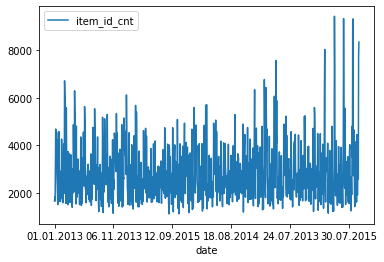

In [11]:
temp2=sales_train.groupby('date')['item_id'].count()
df=pd.DataFrame(temp2)
df.rename(columns={'item_id':'item_id_cnt'},inplace=True)
df.plot()

In [12]:
temp2=sales_train[sales_train['item_id']==5037][sales_train['shop_id']==5][['date','item_cnt_day']]

#Convert datetime type
def str_to_datetime(s):
    split=s.split('.')
    d,m,y=int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=y,month=m,day=d)
temp2['date']=temp2['date'].apply(str_to_datetime).sort_values()
temp2.head()

C:\Users\Jinjin\AppData\Local\Temp/ipykernel_9672/1692404244.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp2=sales_train[sales_train['item_id']==5037][sales_train['shop_id']==5][['date','item_cnt_day']]


,date,item_cnt_day
1953995,2014-09-21,1.0
2150561,2014-11-29,1.0
2288630,2014-12-28,1.0
2288631,2014-12-20,1.0
2335446,2015-01-02,1.0


<AxesSubplot:xlabel='item_price'>

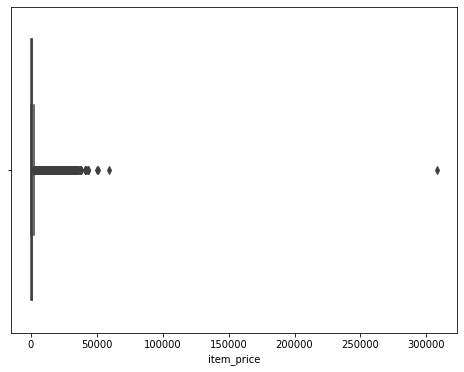

In [13]:
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x=sales_train['item_price'])

In [14]:
train = sales_train[(sales_train.item_price < 250000 )& (sales_train.item_cnt_day < 1000)]
train.loc[train['item_cnt_day'] < 1, "item_cnt_day"] = 0
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# SHOPS DATA SET CLEANING


In [15]:
shops['city']=shops['shop_name'].str.split(" ").map(lambda x:x[0])
shops['category']=shops['shop_name'].str.split(" ").map(lambda x:x[1])
shops.head(3)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ


In [16]:
#Encoder only the main categories, which are most repeated. Put OTHERS for the ones that are not too much repeated.
category=[]
for cat in shops['category'].unique():
    if len(shops[shops['category']==cat])>=5:
        category.append(cat)
shops['category']=shops['category'].apply(lambda x: x if (x in category) else 'others')
shops.head(2)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,others
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ


In [17]:
shops['category']=LabelEncoder().fit_transform(shops.category)
shops['city']=LabelEncoder().fit_transform(shops.city)
shops.head(2)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0,4


# CATEGORIES DATA SET CLEANING


In [18]:
item_categories['type']=item_categories['item_category_name'].apply(lambda x: x.split(' ')[0]).astype(str)
item_categories.head(2)

,item_category_name,item_category_id,type
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары


In [19]:
#Encoder only the main categories, which are most repeated. Put OTHERS for the ones that are not too much repeated.
categ=[]
for cat in item_categories.type.unique():
    if len(item_categories[item_categories.type==cat])>=5:
        categ.append(cat)
item_categories.type=item_categories.type.apply(lambda x: x if (x in categ) else 'others')
item_categories.head(2)

,item_category_name,item_category_id,type
0,PC - Гарнитуры/Наушники,0,others
1,Аксессуары - PS2,1,Аксессуары


In [20]:
item_categories['type_code']=LabelEncoder().fit_transform(item_categories['type'])
item_categories.head(2)

,item_category_name,item_category_id,type,type_code
0,PC - Гарнитуры/Наушники,0,others,0
1,Аксессуары - PS2,1,Аксессуары,1


In [21]:
#Seperating category name into two new columns.
item_categories['split']=item_categories['item_category_name'].apply(lambda x: x.split('-'))
item_categories['sub_type']=item_categories['split'].apply(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
item_categories.head(2)

,item_category_name,item_category_id,type,type_code,split,sub_type
0,PC - Гарнитуры/Наушники,0,others,0,"[PC , Гарнитуры/Наушники]",Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,1,"[Аксессуары , PS2]",PS2


In [22]:
item_categories['sub_type_code']=LabelEncoder().fit_transform(item_categories.sub_type)
item_categories=item_categories[['item_category_id','type_code','sub_type_code']]
item_categories.head(2)

,item_category_id,type_code,sub_type_code
0,0,0,29
1,1,1,9


# ITEMS DATA SET CLEANING

In [23]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [24]:
# split item names by first bracket
items["name1"], items["name2"] = items['item_name'].str.split("[", 1).str
items["name1"], items["name3"] = items['item_name'].str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items['name2'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items['name3'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items = items.fillna('0')

C:\Users\Jinjin\AppData\Local\Temp/ipykernel_9672/172756962.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name2"] = items['item_name'].str.split("[", 1).str
C:\Users\Jinjin\AppData\Local\Temp/ipykernel_9672/172756962.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items["name1"], items["name3"] = items['item_name'].str.split("(", 1).str
C:\Users\Jinjin\AppData\Local\Temp/ipykernel_9672/172756962.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name2"] = items['name2'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
C:\Users\Jinjin\AppData\Local\Temp/ipykernel_9672/172756962.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  items["name3"] = items['name3'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()


In [25]:
#Word correction
items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))
items.head(3)

,item_name,item_id,item_category_id,name1,name2,name3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d


In [26]:
items["name1"][:3]

0                              ! ВО ВЛАСТИ НАВАЖДЕНИЯ 
1    !ABBYY FineReader 12 Professional Edition Full...
2                                  ***В ЛУЧАХ СЛАВЫ   
Name: name1, dtype: object

In [27]:
#Extract key words of name2 column
items["type"] = items['name2'].apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.head(3)

,item_name,item_id,item_category_id,name1,name2,name3,type
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d,0
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0,pc
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d,0


In [28]:
#Cleaning
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [29]:
#"Item_id" counting grouped by "type". The colum "item_id" will be for the new count after grouping
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
group_sum.head(3)

,type,item_id
0,0,17661
1,5c5,1
2,5c7,2


In [30]:
group_sum.type.unique()


array(['0', '5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3',
       'j72', 'kf6', 'kf7', 'kg4', 'mac', 'p', 'pc', 'ps', 'ps2', 'ps3',
       'ps4', 'psp', 's3v', 's4v', 'xbox360', 'xboxone', 'англ', 'рс',
       'русская', 'только', 'цифров', 'цифровая'], dtype=object)

In [31]:
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
drop_cols

['5c5',
 '5c7',
 '5f4',
 '6dv',
 '6jv',
 '6l6',
 'android',
 'hm3',
 'j72',
 'kf6',
 'kf7',
 'kg4',
 'p',
 'ps2',
 's3v',
 's4v',
 'англ',
 'рс',
 'русская',
 'только',
 'цифров']

In [32]:
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [33]:
items[items['name2']=="other"]
#only two item_id had a "name2" column with less than 40 values

,item_name,item_id,item_category_id,name1,name2,name3
721,1с познавательная коллекция поиграем в сказку ...,721,78,1С:Познавательная коллекция. Поиграем в сказку...,other,0
3864,hello 1с,3864,54,"Hello, 1С",other,мастер класс пример быстрой разработки приложе...


In [34]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)
items.drop(["item_name", "name1"],axis = 1, inplace= True)
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,0.0


# SALES (Train) DATAFRAME CLEANING

In [35]:
#Esto es por que se necesita un seguimiento de cada item en cada shop en cada mes
from itertools import product
matrix=[]
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales=train[train.date_block_num==i]
    matrix.append(np.array(list(product( [i], sales.shop_id.unique(), sales.item_id.unique()))))
    
matrix=pd.DataFrame(np.vstack(matrix),columns=cols)
matrix.head(3)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554


In [36]:
matrix['date_block_num']=matrix['date_block_num'].astype(int)
matrix['shop_id']=matrix['shop_id'].astype(np.int8)
matrix['item_id']=matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
matrix.head(3)

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28


In [37]:
train['revenue']=train['item_cnt_day']*train['item_price']
train.head(3)

C:\Users\Jinjin\AppData\Local\Temp/ipykernel_9672/1050904513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['revenue']=train['item_cnt_day']*train['item_price']


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.0,1.0,999.0
1,03.01.2013,0,25,2552,899.0,1.0,899.0
2,05.01.2013,0,25,2552,899.0,0.0,0.0


In [38]:
group=train.groupby(cols).agg({'item_cnt_day':['sum']})
group.columns=['item_cnt_month']
group.reset_index(inplace=True)
group.head(2)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0


In [39]:
#Poner Items_cnt_month in the matrix df
matrix=pd.merge(matrix,group,on=cols,how='left')
matrix['item_cnt_month']=matrix['item_cnt_month'].fillna(0).astype(np.float16)
matrix.head(2)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0


In [40]:
#Juntar TEST df con el matrix df.
test['date_block_num']=34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test['shop_id']=test['shop_id'].astype(np.int8)
test['item_id']=test['item_id'].astype(np.int16)
test.head(2)

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34


In [41]:
test.drop('ID',inplace=True,axis=1)
test.head(2)

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34


In [42]:
matrix=pd.concat([matrix,test],ignore_index=True,sort=False,keys=cols)
matrix.fillna(0,inplace=True)
matrix.tail(3)

,date_block_num,shop_id,item_id,item_cnt_month
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


# JUNTANDO SHOPS Df al MATRIX df

In [43]:
shops.head(2)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0,4


In [44]:
#Two new columns to be added: City and Category
matrix=pd.merge(matrix,shops,on=['shop_id'],how='left')
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0


# JUNTANDO ITEMS Df al MATRIX df

In [45]:
items.head(2)


,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42


In [46]:
#Four new columns to be added: item_category, name2, name3 and type
matrix=pd.merge(matrix,items,on='item_id',how='left')
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42


# JUNTANDO CATEGORIES Df al MATRIX df

In [47]:
item_categories.head(2)


,item_category_id,type_code,sub_type_code
0,0,0,29
1,1,1,9


In [48]:
#TWO new columns to be added: type_code, sub_Type_code
matrix=pd.merge(matrix,item_categories,on='item_category_id',how='left')
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,type_code,sub_type_code
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,5,4
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,3,10
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,3,55


In [49]:
matrix["city"] = matrix["city"].astype(np.int8)
matrix["category"] = matrix["category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["sub_type_code"] = matrix["sub_type_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)

# CREATING LAGS TO THE FEATURES

In [50]:
def lag_feature(df,lags,cols ):
    for col in cols:
        print('Adding lag feature in ',col)
        tmp=df[['date_block_num','shop_id','item_id',col]]
        for i in lags:
            shifted=tmp.copy()
            shifted.columns=['date_block_num','shop_id','item_id',col+'_shifted_'+str(i)]
            shifted.date_block_num=shifted.date_block_num+i
            df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
    return df

## LAG FOR ITEM_CNT_MONTH

In [51]:
matrix=lag_feature(matrix,[1,2,3],["item_cnt_month"])
matrix.head(3)

Adding lag feature in  item_cnt_month


,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,type_code,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,5,4,NaN,NaN,NaN
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,3,10,NaN,NaN,NaN
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,3,55,NaN,NaN,NaN


AVERAGES COUPLES TO DO:
FOR ITEM_COUNT
DATE_BLOCK_NUM & ITEM_CATEGORY_ID (Lag)

DATE_BLOCK_NUM & CATEGORY (Lag)

DATE_BLOCK_NUM (Lag)

DATE_BLOCK_NUM & ITEM_ID (Lag)

FOR ITEM PRICE
ITEM_ID

DATE_BLOCK_NUM & ITEM_ID (Lag)

LAG FOR DATE_ITEM_CAT_AVG¶

In [52]:
#Averaging item_cnt_month by "date_block_num and item_category_id"
group=matrix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_cat_avg']
group.reset_index(inplace=True)
group.head(3)

,date_block_num,item_category_id,date_item_cat_avg
0,0,0,0.022217
1,0,1,0.022217
2,0,2,0.837891


In [53]:
matrix=pd.merge(matrix,group,on=['date_block_num','item_category_id'],how='left')
matrix['date_item_cat_avg']=matrix['date_item_cat_avg'].astype(np.float16)
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,type_code,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3,date_item_cat_avg
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,5,4,NaN,NaN,NaN,0.311279
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,3,10,NaN,NaN,NaN,0.853516
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,3,55,NaN,NaN,NaN,1.192383


In [54]:
matrix=lag_feature(matrix,[1,2],['date_item_cat_avg'])
matrix.drop(['date_item_cat_avg'],axis=1,inplace=True)
matrix.head(3)

Adding lag feature in  date_item_cat_avg


,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,type_code,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,5,4,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,3,10,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,3,55,NaN,NaN,NaN,NaN,NaN


### LAG FOR DATA_CAT_AVG


In [55]:
#Averaging item_cnt_month by "date_block_num and category"
group=matrix.groupby(['date_block_num','category']).agg({'item_cnt_month':['mean']})
group.columns=['date_cat_avg']
group.reset_index(inplace=True)
group.head(2)

,date_block_num,category,date_cat_avg
0,0,0,0.314941
1,0,1,0.278809


In [56]:
matrix=pd.merge(matrix,group,on=['date_block_num','category'],how='left')
matrix['date_cat_avg']=matrix['date_cat_avg'].astype(np.float16)
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,type_code,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,5,4,NaN,NaN,NaN,NaN,NaN,0.314941
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,3,10,NaN,NaN,NaN,NaN,NaN,0.314941
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,3,55,NaN,NaN,NaN,NaN,NaN,0.314941


In [57]:
matrix=lag_feature(matrix,[1,2],['date_cat_avg'])
matrix.drop(['date_cat_avg'],axis=1,inplace=True)
matrix.head(3)

Adding lag feature in  date_cat_avg


,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,type_code,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,3,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### LAG FOR DATE_AVG_ITEM_CNT¶


In [58]:
group=matrix.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns=['date_avg_item_cnt']
group.reset_index(inplace=True)
group.head(3)

,date_block_num,date_avg_item_cnt
0,0,0.361084
1,1,0.341797
2,2,0.385986


In [59]:
matrix=pd.merge(matrix,group,on='date_block_num',how='left')
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,type_code,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361084
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361084
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,3,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.361084


In [60]:
matrix=lag_feature(matrix,[1,2],["date_avg_item_cnt"])
matrix.drop(['date_avg_item_cnt'],inplace=True,axis=1)
matrix.head(3)

Adding lag feature in  date_avg_item_cnt


,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,...,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,...,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### LAG FOR DATE_ITEM_AVG_ITEM_CNT¶


In [61]:
group=matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_avg_item_cnt']
group.reset_index(inplace=True)
group.head(3)

,date_block_num,item_id,date_item_avg_item_cnt
0,0,19,0.022217
1,0,27,0.155518
2,0,28,0.177734


In [62]:
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix.date_item_avg_item_cnt=matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,...,item_cnt_month_shifted_1,item_cnt_month_shifted_2,item_cnt_month_shifted_3,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2,date_item_avg_item_cnt
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022217
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155518
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177734


In [63]:
matrix=lag_feature(matrix,[1,2,3],['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'],inplace=True,axis=1)
matrix.head(3)

Adding lag feature in  date_item_avg_item_cnt


,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,...,item_cnt_month_shifted_3,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_1,date_item_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_3
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### LAG FOR DATE_ITEM_ID_PRICE_AVG

In [64]:
group=train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns=['item_id_price_avg']
group.reset_index(inplace=True)
group.head(3)

,item_id,item_id_price_avg
0,0,58.0
1,1,4490.0
2,2,58.0


In [65]:
matrix=pd.merge(matrix,group,on=['item_id'],how='left')
matrix['item_id_price_avg']=matrix['item_id_price_avg'].astype(np.float16)
matrix.head(3)     

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,...,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_1,date_item_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_3,item_id_price_avg
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.0
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.0


In [66]:
group=train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns=['date_item_id_price_avg']
group.reset_index(inplace=True)
group.head(3)

,date_block_num,item_id,date_item_id_price_avg
0,0,19,28.0
1,0,27,2325.0
2,0,28,549.0


In [67]:
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix['date_item_id_price_avg']=matrix['date_item_id_price_avg'].astype(np.float16)
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,...,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_1,date_item_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_3,item_id_price_avg,date_item_id_price_avg
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,28.0
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.0,2324.0
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.0,549.0


In [68]:
matrix=lag_feature(matrix,[1,2,3],['date_item_id_price_avg'])
matrix.head(3)

Adding lag feature in  date_item_id_price_avg


,date_block_num,shop_id,item_id,item_cnt_month,shop_name,city,category,item_category_id,name2,name3,...,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_1,date_item_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_3,item_id_price_avg,date_item_id_price_avg,date_item_id_price_avg_shifted_1,date_item_id_price_avg_shifted_2,date_item_id_price_avg_shifted_3
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,40,4,42,...,NaN,NaN,NaN,NaN,NaN,28.0,28.0,NaN,NaN,NaN
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,19,77,42,...,NaN,NaN,NaN,NaN,NaN,1461.0,2324.0,NaN,NaN,NaN
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран",0,0,30,108,42,...,NaN,NaN,NaN,NaN,NaN,310.0,549.0,NaN,NaN,NaN


### DROPPING FEATURES

In [69]:
for i in [1,2,3]:
    matrix['delta_price_shifted_'+str(i)]=(matrix['date_item_id_price_avg_shifted_'+str(i)]-matrix['item_id_price_avg'])/matrix['item_id_price_avg']


features_to_drop = ["item_id_price_avg", "date_item_id_price_avg"]

matrix.drop(features_to_drop, axis = 1, inplace = True)

In [70]:
matrix.drop(['shop_name'], axis = 1, inplace = True)

In [71]:
matrix.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 29 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   date_block_num                    int32  
 1   shop_id                           int8   
 2   item_id                           int16  
 3   item_cnt_month                    float16
 4   city                              int8   
 5   category                          int8   
 6   item_category_id                  int8   
 7   name2                             int8   
 8   name3                             int16  
 9   type_code                         int8   
 10  sub_type_code                     int8   
 11  item_cnt_month_shifted_1          float16
 12  item_cnt_month_shifted_2          float16
 13  item_cnt_month_shifted_3          float16
 14  date_item_cat_avg_shifted_1       float16
 15  date_item_cat_avg_shifted_2       float16
 16  date_cat_avg_shifted_1            

### FORECASTING MODEL LGBM

In [72]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [73]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [74]:
train_data = lgbm.Dataset(data=X_train, label=Y_train)
valid_data = lgbm.Dataset(data=X_valid, label=Y_valid)

In [75]:
# configuracion de los parametros
params = {"objective" : "regression", 
          "metric" : "rmse", 
          'n_estimators':10000, 
          'early_stopping_rounds':50,
          "num_leaves" : 2**7-1, 
          "learning_rate" : 0.01, 
          "bagging_fraction" : 0.9,
          "feature_fraction" : 0.3, 
          "bagging_seed" : 0
         }
         
          
# entrenamiento
lgbm_model = lgbm.train(params, 
                        train_data, 
                        valid_sets=[train_data, valid_data], 
                        verbose_eval=1000) 

E:\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
E:\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.439319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4255
[LightGBM] [Info] Number of data points in the train set: 10675632, number of used features: 28
[LightGBM] [Info] Start training from score 0.299710
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[873]	training's rmse: 0.857756	valid_1's rmse: 0.934948


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

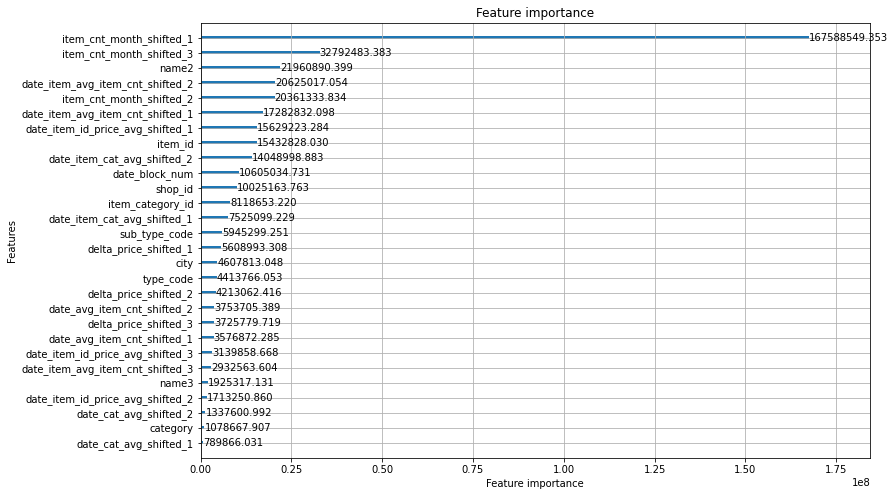

In [76]:
lgbm.plot_importance(
    lgbm_model, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8))

In [77]:
pred=lgbm_model.predict(X_test)


In [78]:
output = pd.DataFrame({'ID': test.index, 'item_cnt_month': pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [80]:
os.getcwd()

'C:\\Users\\Jinjin\\Untitled Folder'